Load libraries,

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Helper Functions

In [2]:
def load_coverage_data(experiment_name, experiment_class, num_trials=5):
    """Load coverage data for all trials of an experiment."""
    data_frames = []
    
    for trial in range(1, num_trials + 1):
        file_path = f"../benchmarks/experiments/{experiment_class}/{experiment_name}/trial{trial}/coverage_data.csv"
        try:
            df = pd.read_csv(file_path)
            df['trial'] = trial
            df['experiment'] = experiment_name
            data_frames.append(df)
        except FileNotFoundError:
            print(f"Warning: Could not find {file_path}")
            continue
    
    if not data_frames:
        raise ValueError(f"No data found for experiment {experiment_name}")
    
    return pd.concat(data_frames, ignore_index=True)

In [3]:
def convert_to_seconds(df):
    """Convert timestamp to seconds from the start of each trial."""
    
    # Parse timestamps
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Group by experiment and trial, then convert to seconds from start
    result_dfs = []
    for (exp, trial), group in df.groupby(['experiment', 'trial']):
        trial_df = group.copy()
        start_time = trial_df['timestamp'].min()
        trial_df['seconds'] = (trial_df['timestamp'] - start_time).dt.total_seconds()
        result_dfs.append(trial_df)
    
    return pd.concat(result_dfs, ignore_index=True)

In [4]:
def create_time_grid(df, max_time=None, step=1):
    """Create a regular time grid for interpolation."""
    if max_time is None:
        max_time = df['seconds'].max()
    return np.arange(0, max_time + step, step)

In [5]:
def interpolate_coverage(df, time_grid):
    """Interpolate coverage values to a regular time grid."""
    result_dfs = []
    
    for (exp, trial), group in df.groupby(['experiment', 'trial']):
        interpolated_data = {'experiment': exp, 'trial': trial, 'seconds': time_grid}
        
        # Interpolate each coverage type
        for col in ['line_coverage', 'branch_coverage', 'function_coverage']:
            interpolated_data[col] = np.interp(time_grid, group['seconds'], group[col])
        
        result_dfs.append(pd.DataFrame(interpolated_data))
    
    return pd.concat(result_dfs, ignore_index=True)

In [6]:
def calculate_statistics(df, coverage_type):
    """
    For every (experiment, seconds) pair compute mean and 95 % CI.
    Returns a data-frame with columns:
        experiment  seconds  mean  se  lo  hi
    """
    stats = (df
             .groupby(['experiment', 'seconds'])[coverage_type]
             .agg(['mean', 'std', 'count'])
             .reset_index())

    stats['se'] = stats['std'] / np.sqrt(stats['count'])

    # 95 % confidence interval (≈ ±1.96 · SE)
    ci = 1.96 * stats['se']
    stats['lo'] = stats['mean'] - ci
    stats['hi'] = stats['mean'] + ci

    # Keep only what we need
    return stats[['experiment', 'seconds', 'mean', 'se', 'lo', 'hi', 'std']]


#### Styling

In [7]:
#  Colour & linestyle mappings  (colour-blind safe)
_COLOURS = {
	"grammarinator": "#7f7f7f",  # grey
	"asap":          "#d62728",  # olive
	"gcd":           "#9467bd",  # orange
	"mcmc_prefix":   "#1f77b4",  # blue
	"mcmc_priority": "#ff7f0e",  # green
	"mcmc_restart":  "#2ca02c",  # purple
}

_LINESTYLES = {"2": ":", "5": "--", "10": "-"}

def _style(exp_name):
	"""Return (label, colour, linestyle, marker_every) for a given experiment."""
	if exp_name == 'grammarinator':
		return (exp_name.capitalize(), _COLOURS[exp_name], "-", 200)
	if exp_name == 'asap':
		return ('ASAp', _COLOURS[exp_name], "-", 200)
	elif exp_name == 'gcd':
		return ('GCD', _COLOURS[exp_name], "-", 200)

	# parse MCMC variant: mcmc_<family>_<k>
	_, family, k = exp_name.split("_")
	if family == 'prefix':
		label = f'MCMC-Uniform-{k}'
	else:
		label = f"MCMC–{family.capitalize()}-{k}"
	colour = _COLOURS[f"mcmc_{family}"]
	ls = _LINESTYLES[k]

	return (label, colour, ls, 200)

#### Main function to visualize experiments

In [8]:
def plot_experiment_comparison(experiment_names, experiment_class, coverage_type, plot_name="", max_time=None, save_plot=False):
	"""Create a line chart comparing different experiments for a single coverage type."""
	
	# Load all experimental data
	all_data = []
	for exp_name in experiment_names:
		try:
			df = load_coverage_data(exp_name, experiment_class)
			all_data.append(df)
		except Exception as e:
			print(f"Could not load {exp_name}: {e}")
			continue
	
	if not all_data:
		raise ValueError("No experimental data could be loaded")
	
	# Combine all data
	combined_df = pd.concat(all_data, ignore_index=True)
	combined_df = convert_to_seconds(combined_df)
	
	# Create regular time grid for interpolation
	time_grid = create_time_grid(combined_df, max_time)
	interpolated_df = interpolate_coverage(combined_df, time_grid)
	
	# Calculate statistics
	stats = calculate_statistics(interpolated_df, coverage_type)
	
	# Create figure and axis with a white background
	# Increase figure width to accommodate legend on the right
	plt.rcParams.update({
	'font.size': 24,          # Base font size
	'axes.titlesize': 10,     # Title font size
	'axes.labelsize': 28,     # Axis labels
	'legend.fontsize': 24,    # Legend font size
	'xtick.labelsize': 20,    # X-axis tick labels
	'ytick.labelsize': 20,    # Y-axis tick labels
	'lines.linewidth': 5,     # Make lines thicker
	'lines.markersize': 20,   # Make markers bigger
})

	fig, ax = plt.subplots(figsize=(12, 10))
	ax.set_facecolor('white')
	fig.patch.set_facecolor('white')
	
	# Configure the grid to match the example
	ax.grid(True, linestyle='--', color='lightgray', alpha=0.7)
	ax.set_axisbelow(True)  # Place grid behind data points
		
	# Plot each experiment
	for i, exp_name in enumerate(experiment_names):
		exp_stats = stats[stats['experiment'] == exp_name]
		
		label, colour, ls, mark_every = _style(exp_name)
				
		# Determine marker frequency - we want to show fewer markers when there are many data points
		total_points = len(exp_stats)
		
		# Show approximately 15 markers regardless of data density
		marker_every = max(1, total_points // 15)
		
		# Plot the confidence intervals (using standard error)
		upper = exp_stats['mean'] + exp_stats['se']
		lower = exp_stats['mean'] - exp_stats['se']
		ax.fill_between(exp_stats['seconds'], lower, upper,
						alpha=0.2, color=colour, label='_nolegend_')
				
		# Plot the mean line with markers at intervals
		ax.plot(exp_stats['seconds'], exp_stats['mean'], 
				marker='o', markersize=4.0, linestyle=ls, linewidth=3.0,
				color=colour, label=f"{label}", 
				markevery=marker_every,
				markeredgewidth=2.0,
				markeredgecolor=colour, markerfacecolor=colour)
	
	# Add info
	ax.set_xlabel('Time (seconds)', fontweight='normal')
	ax.set_ylabel(f'{coverage_type.replace("_", " ").title()} (%)', fontweight='normal')
	ax.tick_params(axis='both', which='major')
	ax.legend(loc='best', frameon=True) 
	plt.tight_layout()
	
	if save_plot:
		plt.savefig(f'../figures/{plot_name}.png', dpi=300, bbox_inches='tight')
	return fig, ax

### Visualize
- select experiment name(s)
- select experiment class between {xml, sql}
- select coverage type between {line_coverage, branch_coverage, function_coverage}
- (optional) name for saving plots

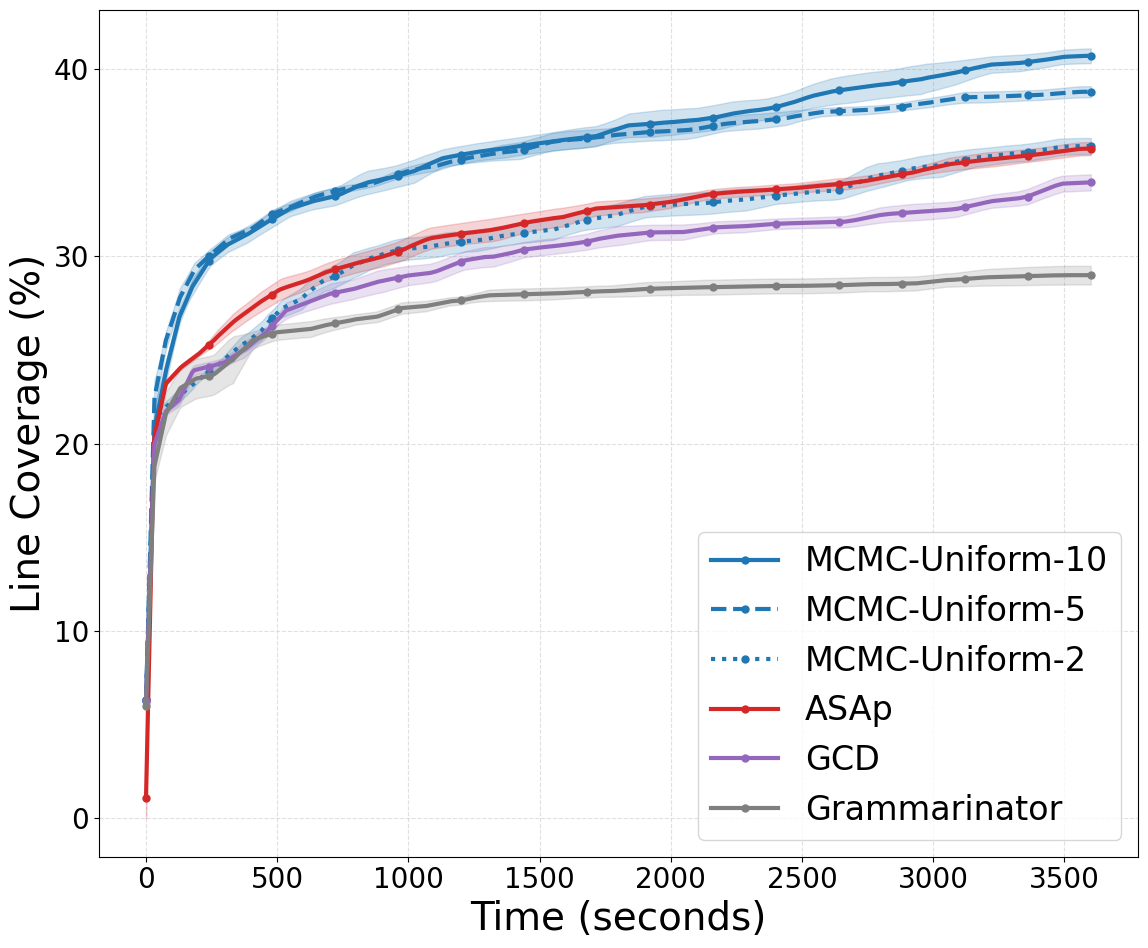

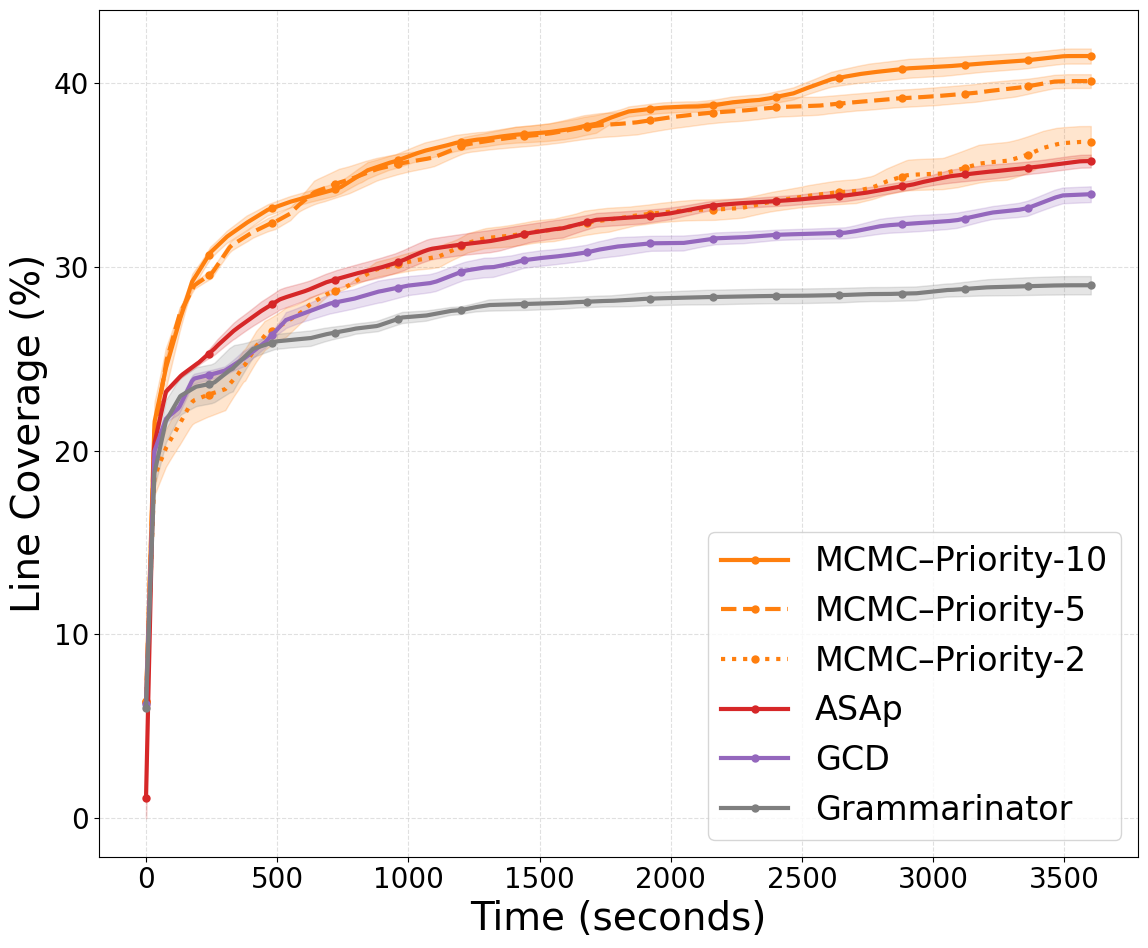

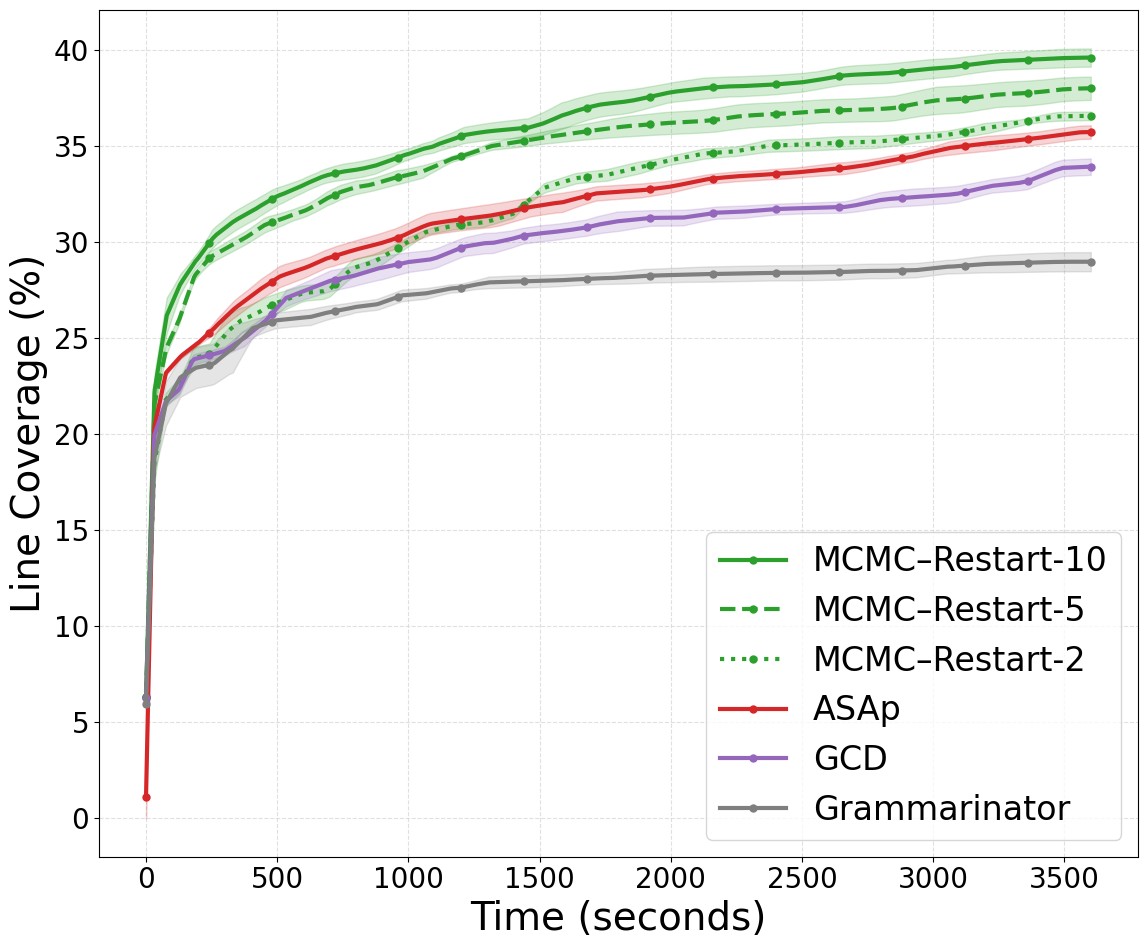

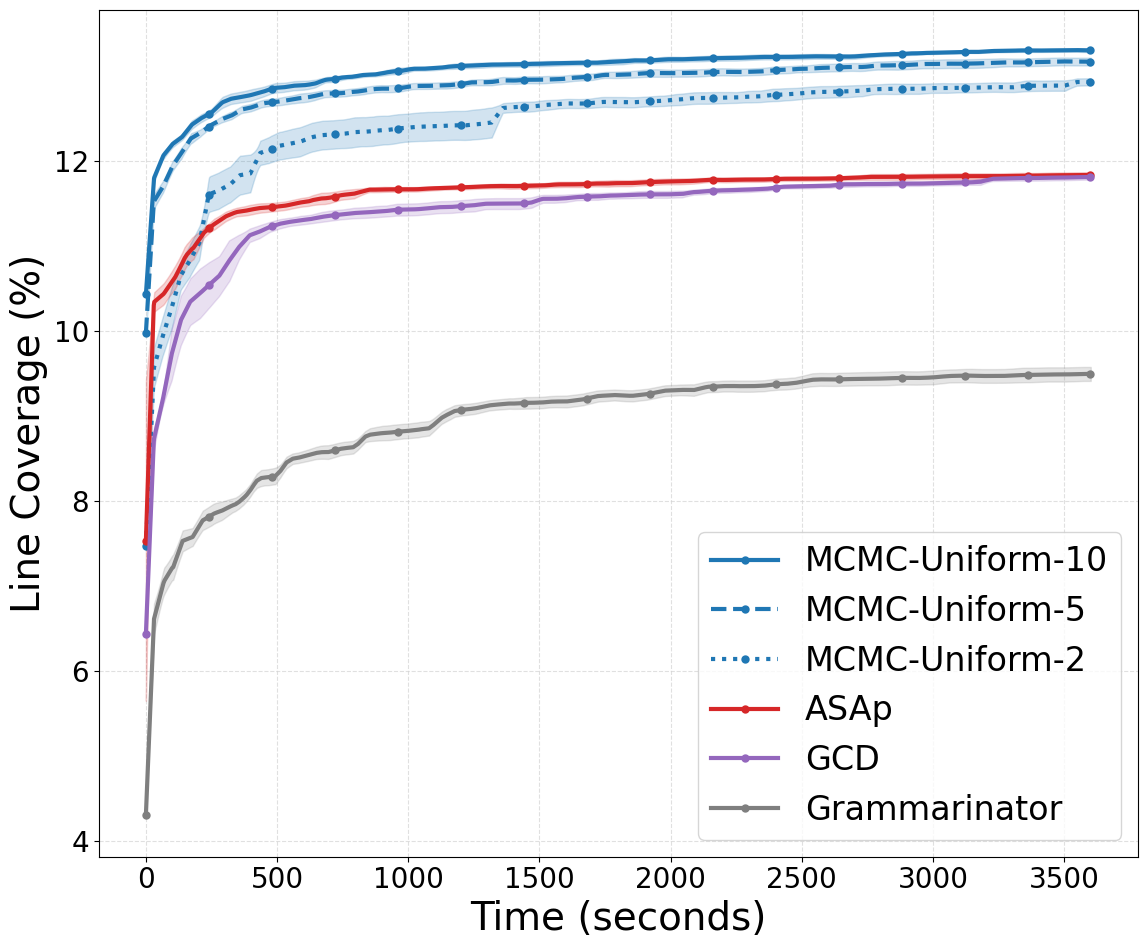

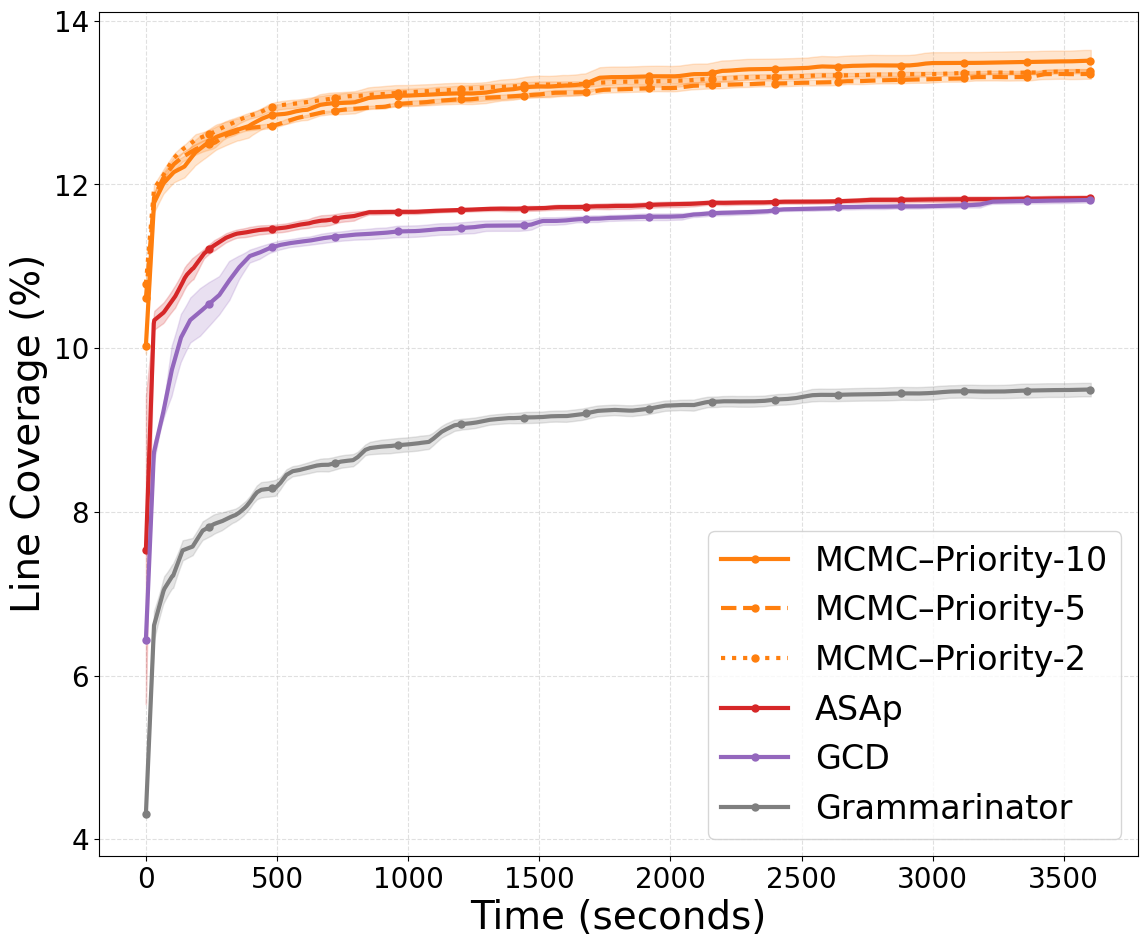

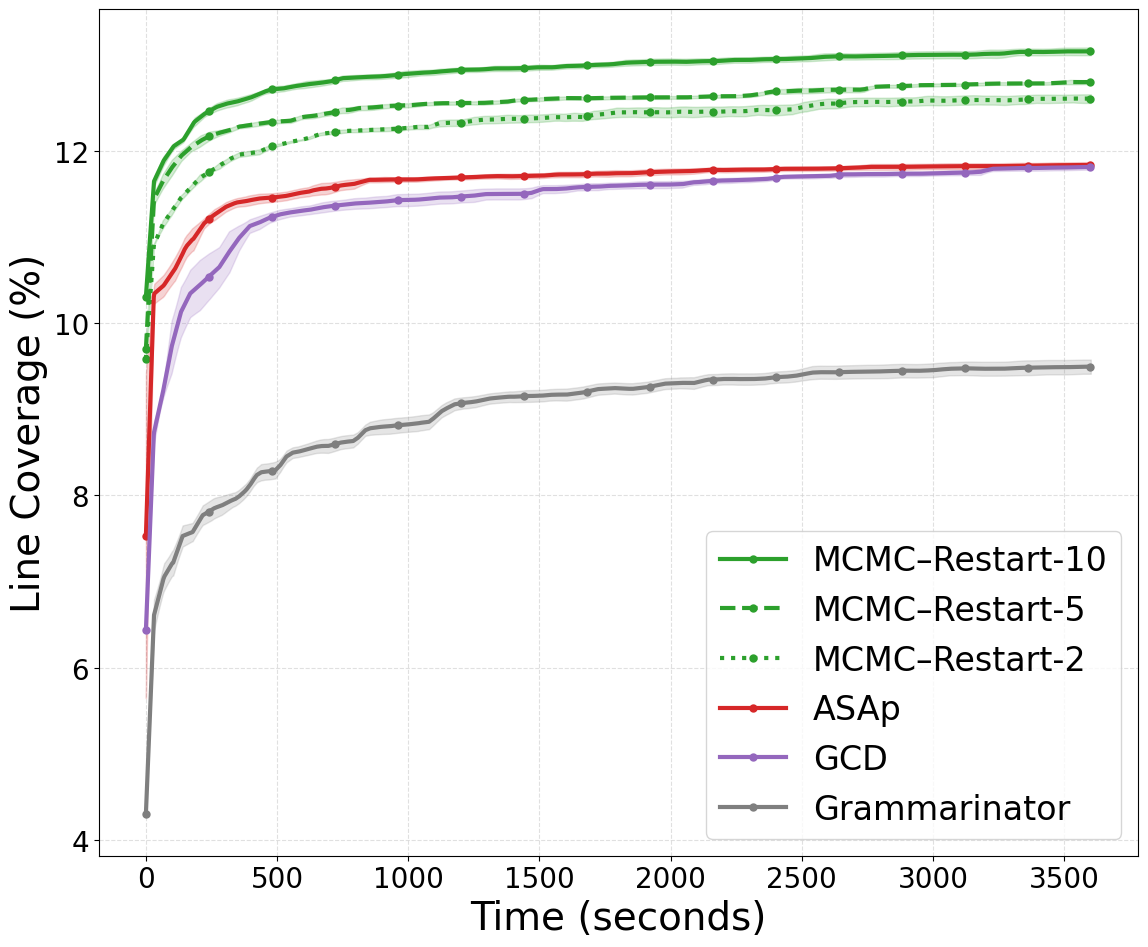

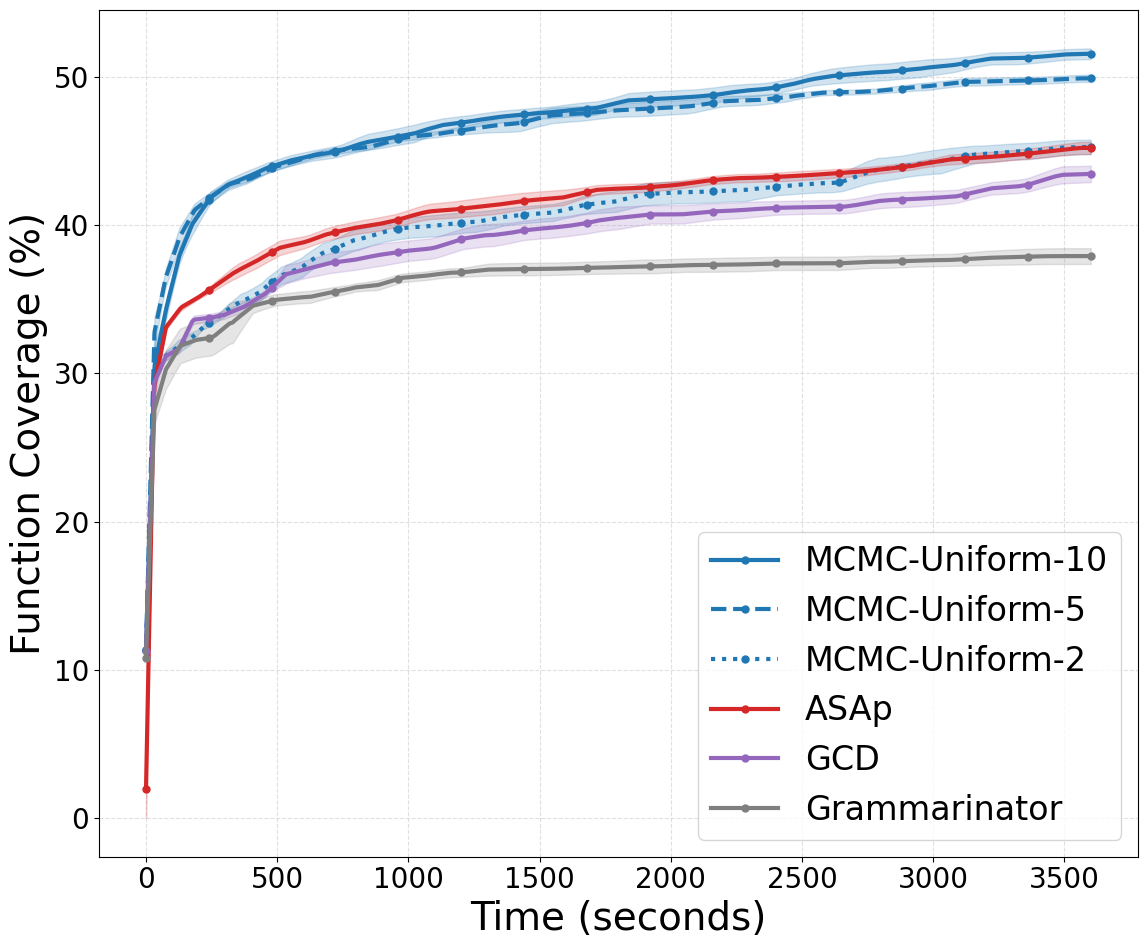

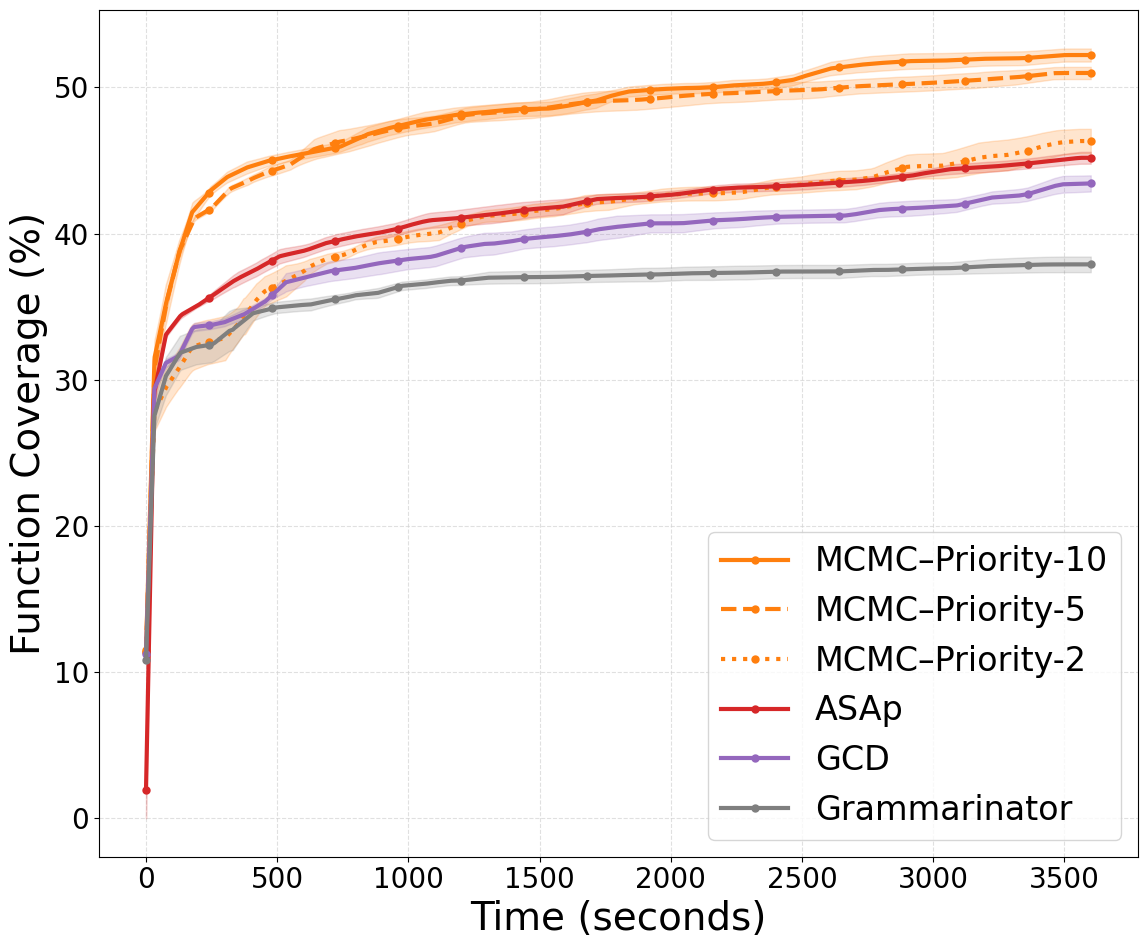

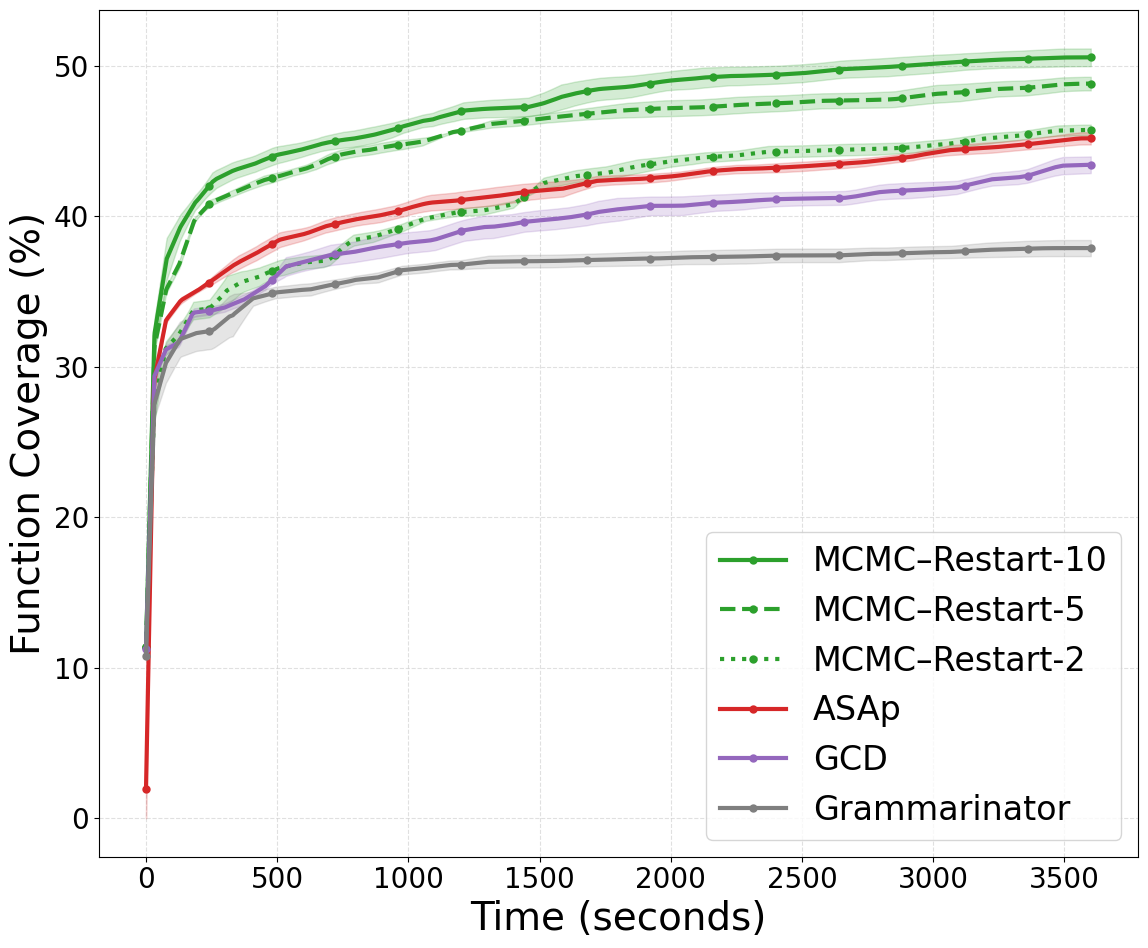

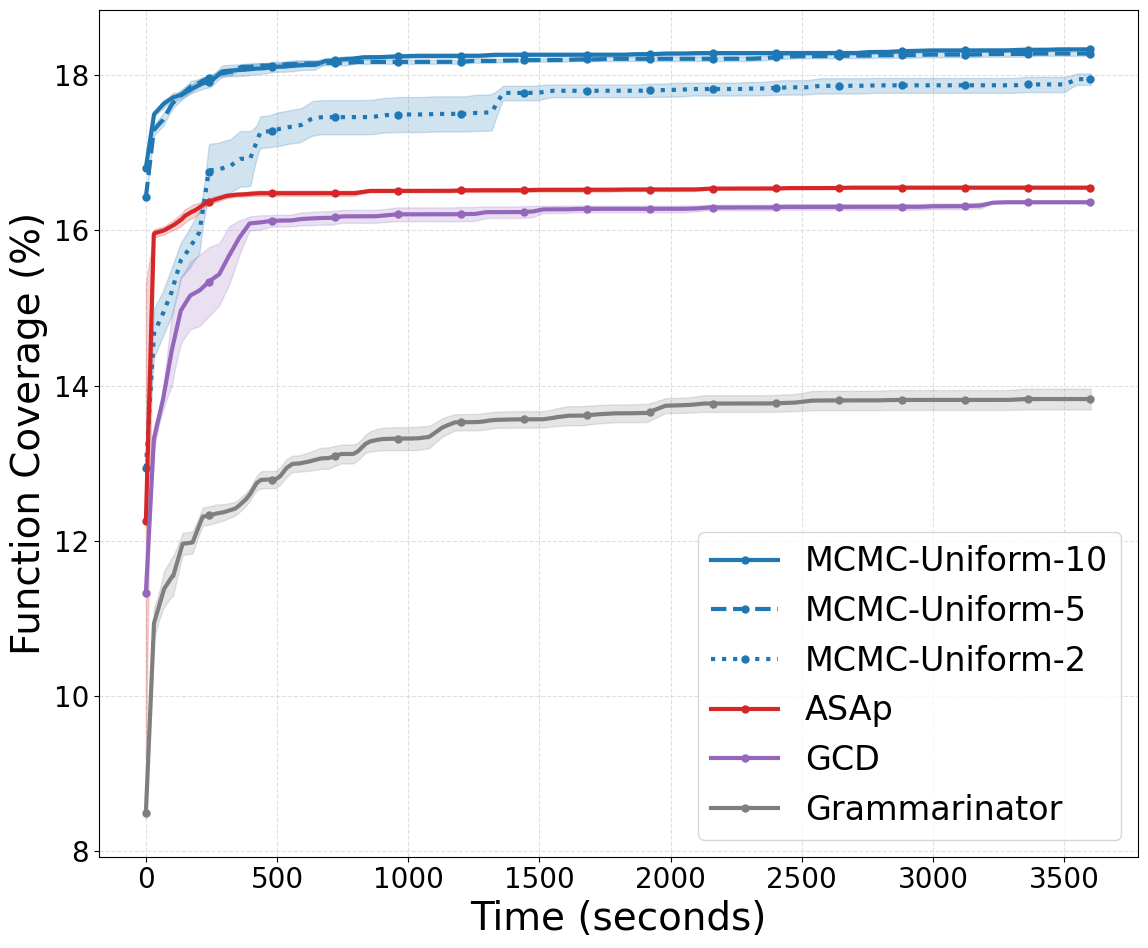

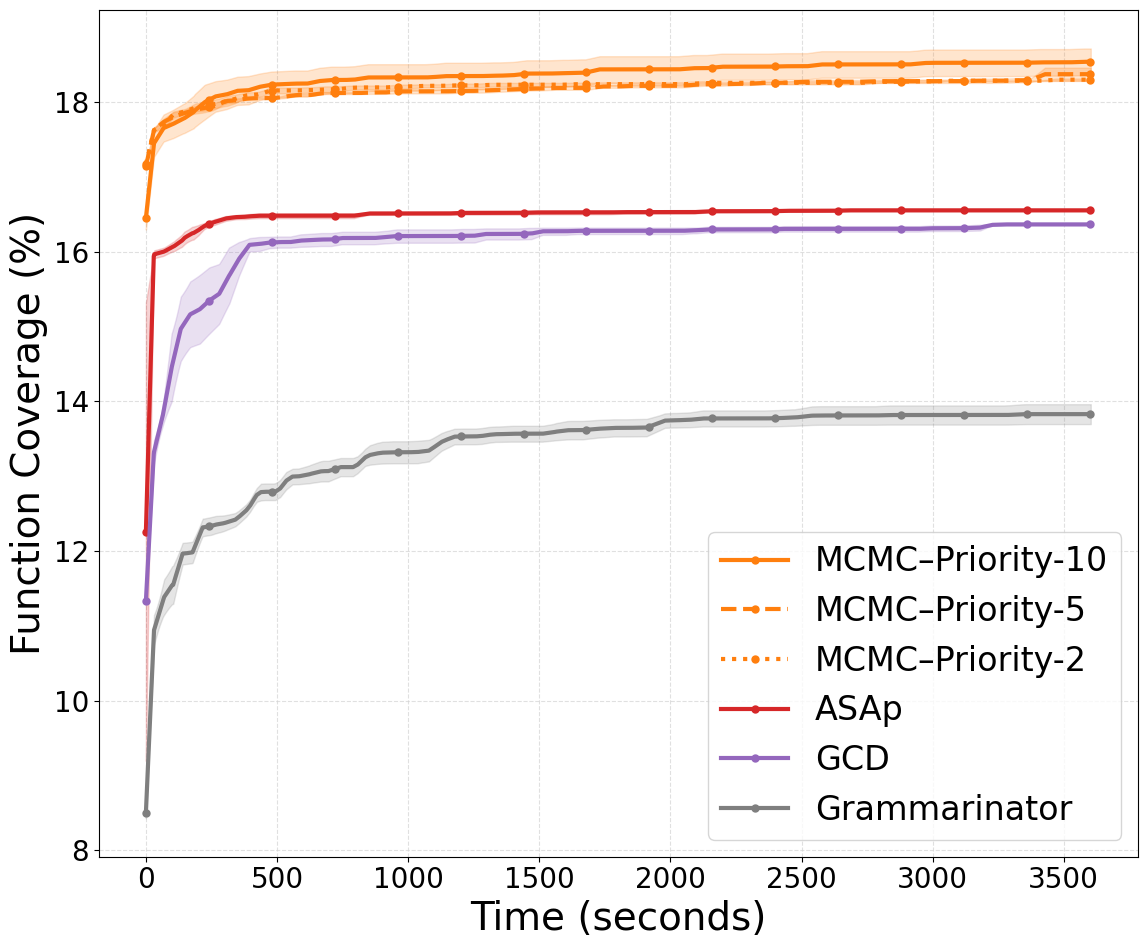

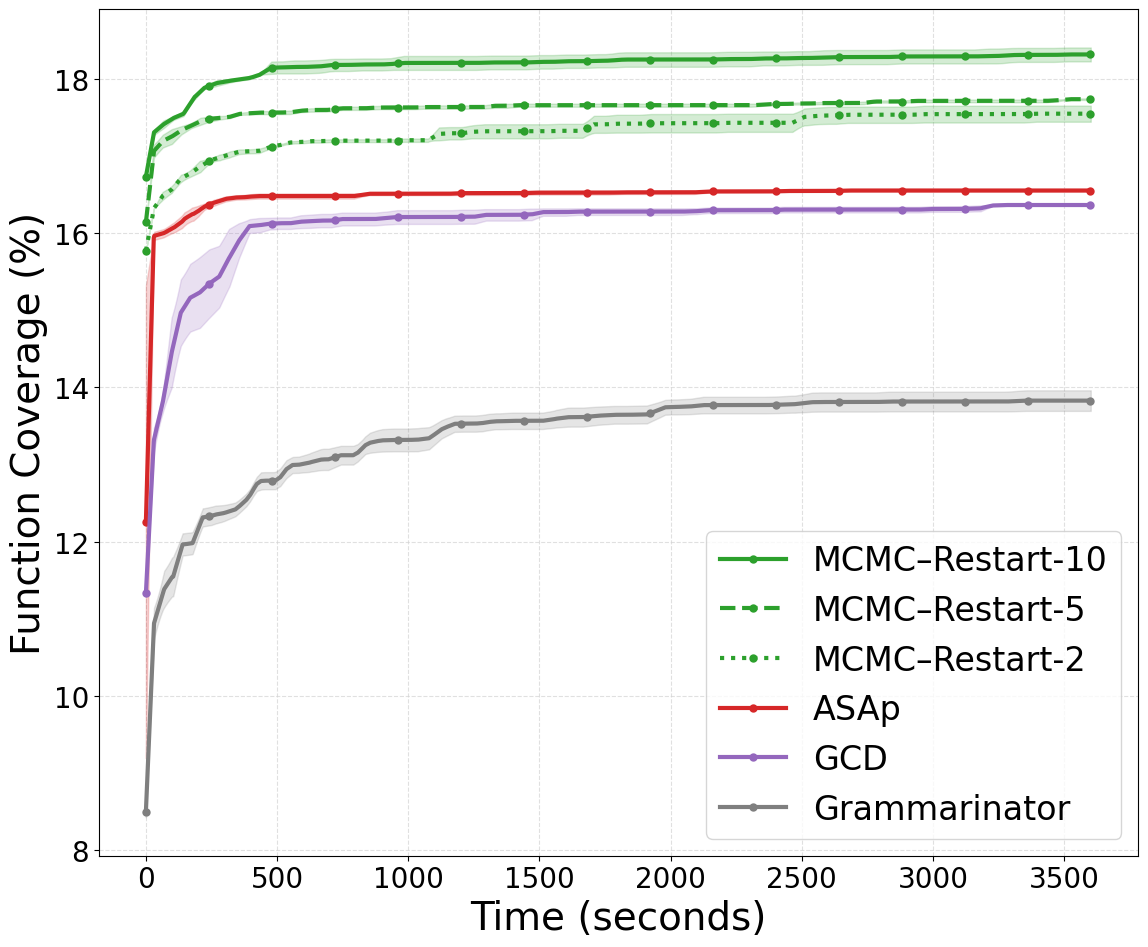

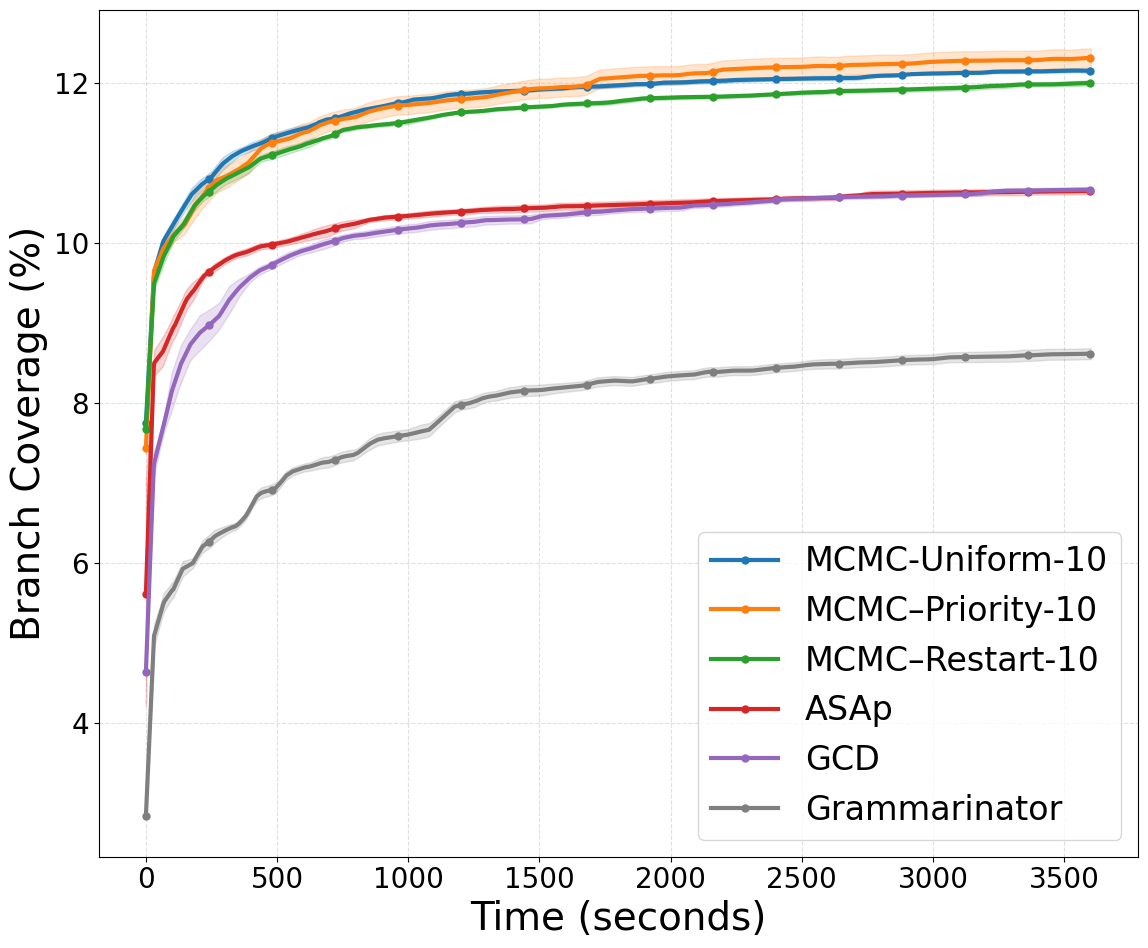

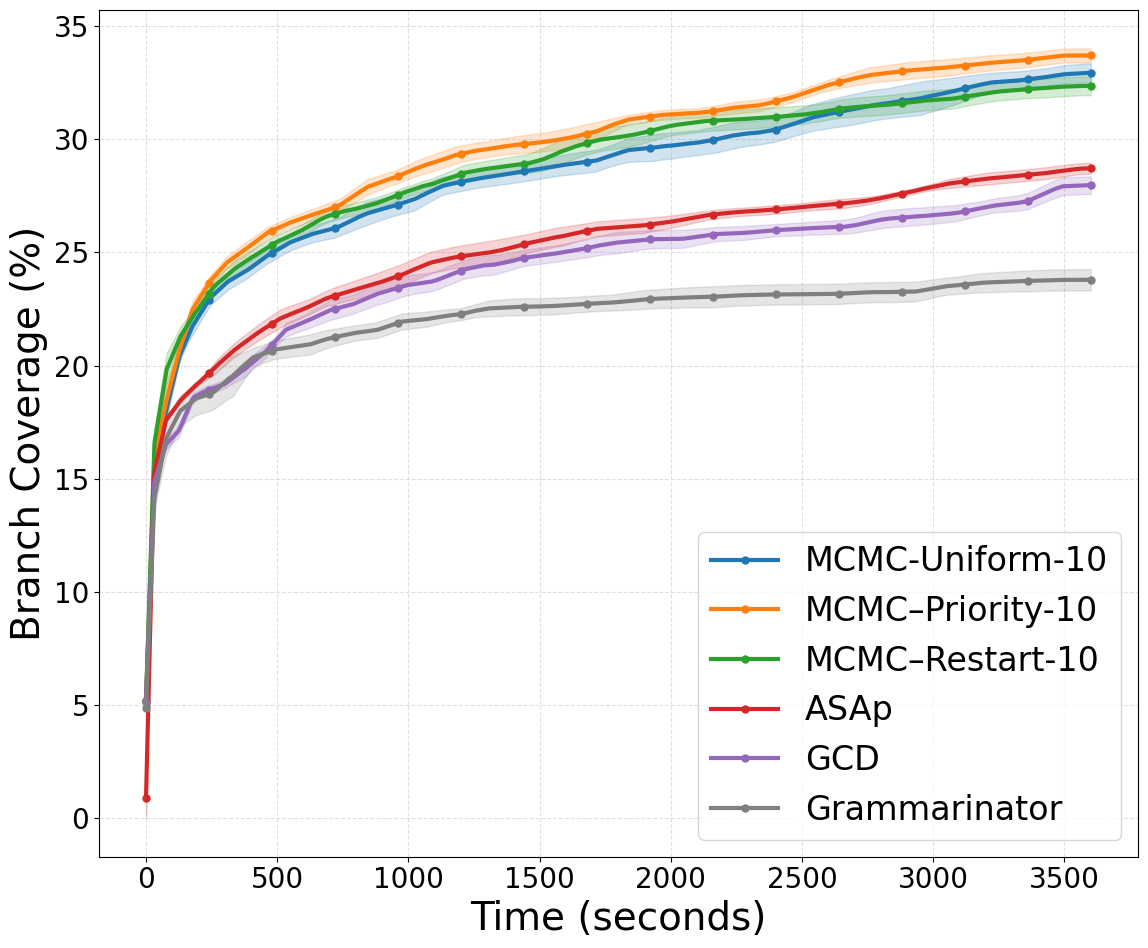

In [9]:
experiment_names = [ "mcmc_prefix_10", "mcmc_prefix_5", "mcmc_prefix_2", "asap", "gcd", "grammarinator"]
plots_map = {
	"sql_prefix_line_coverage": [ "mcmc_prefix_10", "mcmc_prefix_5", "mcmc_prefix_2", "asap", "gcd", "grammarinator"],
	"sql_priority_line_coverage": [ "mcmc_priority_10", "mcmc_priority_5", "mcmc_priority_2", "asap", "gcd", "grammarinator"],
	"sql_restart_line_coverage": [ "mcmc_restart_10", "mcmc_restart_5", "mcmc_restart_2", "asap", "gcd", "grammarinator"],
}

for plot_name, exp_names in plots_map.items():
	fig, ax = plot_experiment_comparison(exp_names, "sql", 'line_coverage',  plot_name=plot_name, save_plot=False) 

plots_map = {
	"xml_prefix_line_coverage": [ "mcmc_prefix_10", "mcmc_prefix_5", "mcmc_prefix_2", "asap", "gcd", "grammarinator"],
	"xml_priority_line_coverage": [ "mcmc_priority_10", "mcmc_priority_5", "mcmc_priority_2", "asap", "gcd", "grammarinator"],
	"xml_restart_line_coverage": [ "mcmc_restart_10", "mcmc_restart_5", "mcmc_restart_2", "asap", "gcd", "grammarinator"],
}
for plot_name, exp_names in plots_map.items():
	fig, ax = plot_experiment_comparison(exp_names, "xml", 'line_coverage',  plot_name=plot_name)   

plots_map = {
	"sql_prefix_function_coverage": [ "mcmc_prefix_10", "mcmc_prefix_5", "mcmc_prefix_2", "asap", "gcd", "grammarinator"],
	"sql_priority_function_coverage": [ "mcmc_priority_10", "mcmc_priority_5", "mcmc_priority_2", "asap", "gcd", "grammarinator"],
	"sql_restart_function_coverage": [ "mcmc_restart_10", "mcmc_restart_5", "mcmc_restart_2", "asap", "gcd", "grammarinator"],
}
for plot_name, exp_names in plots_map.items():
	fig, ax = plot_experiment_comparison(exp_names, "sql", 'function_coverage',  plot_name=plot_name)

plots_map = {
	"xml_prefix_function_coverage": [ "mcmc_prefix_10", "mcmc_prefix_5", "mcmc_prefix_2", "asap", "gcd", "grammarinator"],
	"xml_priority_function_coverage": [ "mcmc_priority_10", "mcmc_priority_5", "mcmc_priority_2", "asap", "gcd", "grammarinator"],
	"xml_restart_function_coverage": [ "mcmc_restart_10", "mcmc_restart_5", "mcmc_restart_2", "asap", "gcd", "grammarinator"],
}
for plot_name, exp_names in plots_map.items():
	fig, ax = plot_experiment_comparison(exp_names, "xml", 'function_coverage', plot_name=plot_name)      


plots_map = {
	"xml_top_compare": [ "mcmc_prefix_10", "mcmc_priority_10", "mcmc_restart_10", "asap", "gcd", "grammarinator"],
}
for plot_name, exp_names in plots_map.items():
	fig, ax = plot_experiment_comparison(exp_names, "xml", 'branch_coverage', plot_name=plot_name)   
 
 
plots_map = {
	"sql_top_compare": [ "mcmc_prefix_10", "mcmc_priority_10", "mcmc_restart_10", "asap", "gcd", "grammarinator"],
}
for plot_name, exp_names in plots_map.items():
	fig, ax = plot_experiment_comparison(exp_names, "sql", 'branch_coverage', plot_name=plot_name)   


### Other Examples

In [10]:
# plots_map = {
# 	"xml_prefix_line_coverage": [ "mcmc_prefix_10", "mcmc_prefix_5", "mcmc_prefix_2", "asap", "gcd", "grammarinator"],
# 	"xml_priority_line_coverage": [ "mcmc_priority_10", "mcmc_priority_5", "mcmc_priority_2", "asap", "gcd", "grammarinator"],
# 	"xml_restart_line_coverage": [ "mcmc_restart_10", "mcmc_restart_5", "mcmc_restart_2", "asap", "gcd", "grammarinator"],
# }
# for plot_name, exp_names in plots_map.items():
# 	fig, ax = plot_experiment_comparison(exp_names, "xml", 'line_coverage',  plot_name=plot_name)   

# plots_map = {
# 	"sql_prefix_function_coverage": [ "mcmc_prefix_10", "mcmc_prefix_5", "mcmc_prefix_2", "asap", "gcd", "grammarinator"],
# 	"sql_priority_function_coverage": [ "mcmc_priority_10", "mcmc_priority_5", "mcmc_priority_2", "asap", "gcd", "grammarinator"],
# 	"sql_restart_function_coverage": [ "mcmc_restart_10", "mcmc_restart_5", "mcmc_restart_2", "asap", "gcd", "grammarinator"],
# }
# for plot_name, exp_names in plots_map.items():
# 	fig, ax = plot_experiment_comparison(exp_names, "sql", 'function_coverage',  plot_name=plot_name)

# plots_map = {
# 	"xml_prefix_function_coverage": [ "mcmc_prefix_10", "mcmc_prefix_5", "mcmc_prefix_2", "asap", "gcd", "grammarinator"],
# 	"xml_priority_function_coverage": [ "mcmc_priority_10", "mcmc_priority_5", "mcmc_priority_2", "asap", "gcd", "grammarinator"],
# 	"xml_restart_function_coverage": [ "mcmc_restart_10", "mcmc_restart_5", "mcmc_restart_2", "asap", "gcd", "grammarinator"],
# }
# for plot_name, exp_names in plots_map.items():
# 	fig, ax = plot_experiment_comparison(exp_names, "xml", 'function_coverage', plot_name=plot_name)      